## Generate Time Series for the 3 accelerometer channels and 3 gyroscope channels

This script must be run from the same directory as the scripts which it imports.

In [1]:
%run preprocess.ipynb
%run sys_configs.ipynb

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

np.random.seed(123)

Choose a trainer and sample 5 minutes of time series observations from the time series for that trainer.

In [2]:
trainer = 5
sample_sz = 50 * 60 * 5

In [3]:
# Sample the trainer, reset the index, then take a sample of length sample_sz
sample_data = data.loc[data["trainer"] == trainer]
sample_data = sample_data.reset_index(drop = True)

start_index = np.random.randint(0, len(sample_data) - sample_sz + 1)  # Generate a random start index
sample_data = sample_data.iloc[start_index:start_index + sample_sz]

Assign an exercise_id based on a mask triggered when the activity changes, for the purposes of this visualisation only

In [4]:
activity_mask = sample_data['activity'].ne(sample_data['activity'].shift())
sample_data['exercise_id'] = activity_mask.cumsum()

sample_data.head(2)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity,trainer,time,exercise_id
118270,-0.942383,0.331543,0.101074,-2.75,4.375,2.2500,0,5,2365.40,1
118271,-0.948730,0.333008,0.094727,0.25,5.125,3.4375,0,5,2365.42,1


In [5]:
# Display the first and last times of each "exercise" to understand which activities in the sample
sample_data.groupby('exercise_id').agg(activity=('activity', 'first'), first_time=('time', 'first'), last_time= ('time', 'last'))

,activity,first_time,last_time
exercise_id,,,
1,0,2365.40,2381.70
2,1,2381.72,2407.08
3,0,2407.10,2451.34
4,2,2451.36,2478.28
5,0,2478.30,2576.92
6,3,2576.94,2601.88
7,0,2601.90,2660.16
8,4,2660.18,2665.38


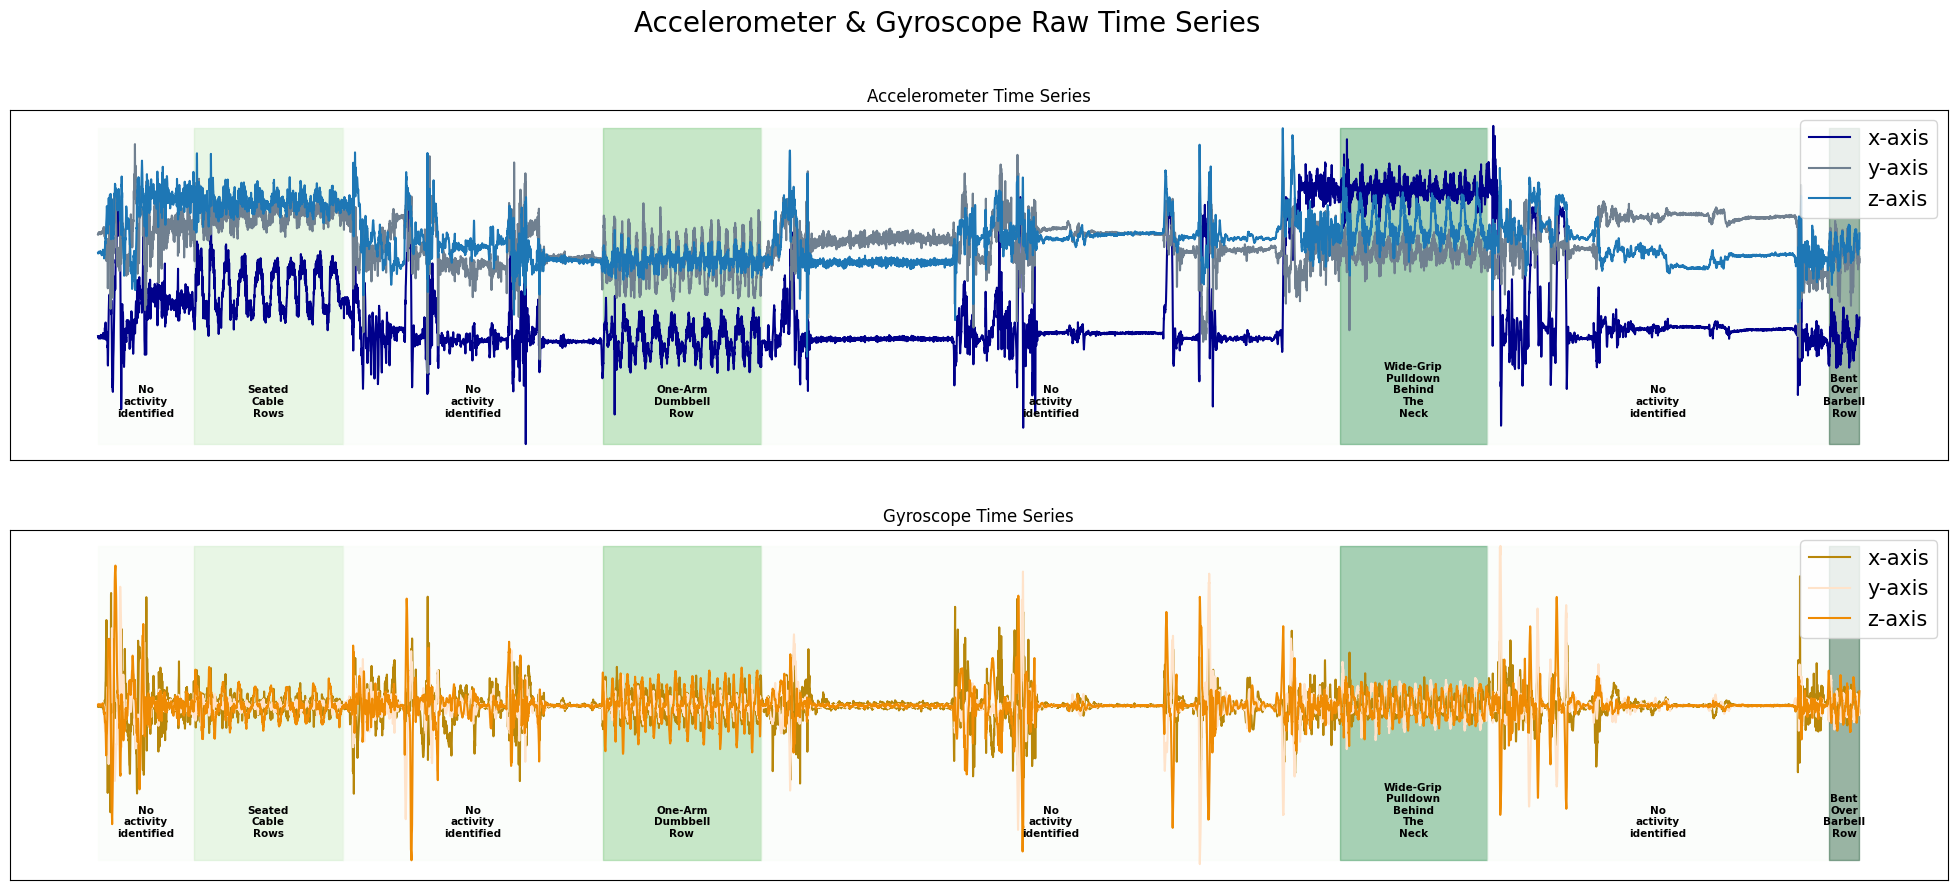

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(25,10))
fig.suptitle("Accelerometer & Gyroscope Raw Time Series", fontsize = 20)

colours = {"acc": ["#00008B", "#708090", "#1E77B5"], "gyr": ["#B8870A", "#FFE3CA", "#EF8B03"]}

t = sample_data.time
acc_x = sample_data.acc_x
acc_y = sample_data.acc_y
acc_z = sample_data.acc_z
gyr_x = sample_data.gyr_x
gyr_y = sample_data.gyr_y
gyr_z = sample_data.gyr_z
activities = sample_data.activity

# Get the min and max accelerometer and gyroscope readings across all the samples
acc_max = max(max(acc_y), max(acc_y), max(acc_z))
acc_min = min(min(acc_x), min(acc_x), min(acc_z))
gyr_max = max(max(gyr_y), max(gyr_y), max(gyr_z))
gyr_min = min(min(gyr_x), min(gyr_x), min(gyr_z))

# Plot the x, y and z co-ordinate accelerometer readings
ax[0].plot(t, acc_x, color = colours.get("acc")[0], label = "x-axis")
ax[0].yaxis.label.set_size(15)
ax[0].plot(t, acc_y, color = colours.get("acc")[1], label = "y-axis")
ax[0].yaxis.label.set_size(15)
ax[0].plot(t, acc_z, color = colours.get("acc")[2], label = "z-axis")
ax[0].yaxis.label.set_size(15)

ax[0].get_yaxis().set_visible(False)
ax[0].legend(loc="upper right")

# Plot the x, y and z co-ordinate gyroscope readings
ax[1].plot(t, gyr_x, color = colours.get("gyr")[0], label = "x-axis")
ax[1].yaxis.label.set_size(15)
ax[1].plot(t, gyr_y, color = colours.get("gyr")[1], label = "y-axis")
ax[1].yaxis.label.set_size(15)
ax[1].plot(t, gyr_z, color = colours.get("gyr")[2], label = "z-axis")
ax[1].yaxis.label.set_size(15)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].legend(loc="upper right", fontsize = 15)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].legend(loc="upper right", fontsize = 15)    

# Partition the workout by exercise id. Some activities will be repeated. Find the highest and lowest timestamps.
exercises = sample_data.groupby('exercise_id').agg(activity=('activity', 'first'), first_time=('time', 'first'), last_time= ('time', 'last'))

# Define the colormap, generate equally spaced values between 0 and 1, then map the colours to the colourmap. Convert to hex.
cmap = plt.cm.Greens
num_colours = len(exercises["activity"].unique())
values = np.linspace(0, 1, num_colours)
colors = cmap(values)
hex_colors = [mcolors.to_hex(color) for color in colors]
activity_colours = {item: hex_colors[idx] for idx, item in enumerate(exercises["activity"].unique())}    

for idx, row in exercises.iterrows():
    # Fill the accelerometer and gyroscope data with a colour unique to the activity
    ax[0].fill_betweenx([acc_min, acc_max], row["first_time"], row["last_time"], color=activity_colours[row["activity"]], alpha=0.4, label=ACTIVITY_MAPPING[row["activity"]])
    ax[1].fill_betweenx([gyr_min, gyr_max], row["first_time"], row["last_time"], color=activity_colours[row["activity"]], alpha=0.4, label=ACTIVITY_MAPPING[row["activity"]])

    # Add the activity label to the accelerometer and gyroscope plots. The label is inserted into the middle of each exercise data.
    ax[0].text(
        (row["first_time"] + row["last_time"]) / 2,
        acc_min * 0.85,
        s = ACTIVITY_MAPPING[row["activity"]].replace(" ", "\n"),
        horizontalalignment='center',
        weight='bold',
        fontsize=7.5
    )


    ax[1].text(
        (row["first_time"] + row["last_time"]) / 2,
        gyr_min * 0.85,
        s = ACTIVITY_MAPPING[row["activity"]].replace(" ", "\n"),
        horizontalalignment='center',
        weight='bold',
        fontsize=7.5
    )

ax[0].set_title('Accelerometer Time Series')
ax[1].set_title('Gyroscope Time Series')
plt.savefig('RawTimeSeriesPlot.pdf', dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()